In [20]:
import json
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor, default_argument_parser, default_setup
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

from deepent.data.register_datasets import register_datasets
from deepent.config import add_deepent_config

In [4]:
register_datasets(f'/home/ubuntu/RGBD-Tree-Segs/')

Registering Kelowna_train
Registering AMECT9_train
Registering SALCT1_train
Registering CPT2b_train
Registering CPT2a-n_train
Registering Kelowna_test
Registering AMECT9_test
Registering SALCT1_test
Registering CPT2b_test
Registering CPT2a-n_test


In [48]:
config_file = '../configs/deepent_rcnn_R_50_FPN.yaml'
threshold = 0.5
model = '../output/baseline_17_01_2019/model_0019999.pth'
samples = 1
dataset = 'CPT2a-n_train'
type_ = 'many'
opts = []

class Args:
    def __init__(self, conf, tr, mod, sam, ty, opt, dts):
        self.config_file = conf
        self.threshold = tr
        self.model = mod
        self.samples = sam
        self.dataset = dts
        self.type = ty
        self.opts = []
        self.output = None
        
args = Args(config_file, threshold, model, samples, type_, opts, dataset)

In [15]:
with open(config_file, 'r') as f:
    print(f.read())

_BASE_: "Base-DeepEnt-RCNN-FPN.yaml"
MODEL:
  BACKBONE:
    NAME: "build_resnet_fpn_backbone"
  WEIGHTS: "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
  MASK_ON: True
  RESNETS:
    DEPTH: 50
INPUT:
  FORMAT: "BGR"



In [49]:
cfg = get_cfg()
add_deepent_config(cfg)
cfg.merge_from_file(config_file)
cfg.merge_from_list(opts)
cfg.MODEL.WEIGHTS = model 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold 
cfg.freeze()
default_setup(cfg, args)

[01/20 05:02:03 detectron2]: Rank of current process: 0. World size: 1
[01/20 05:02:04 detectron2]: Environment info:
------------------------  --------------------------------------------------------------------------------------
sys.platform              linux
Python                    3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) [GCC 7.2.0]
numpy                     1.15.4
detectron2                0.1 @/home/ubuntu/drone-tree-id/lib/detectron2/detectron2
detectron2 compiler       GCC 5.4
detectron2 CUDA compiler  10.1
detectron2 arch flags     sm_75
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.3.1 @/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch
PyTorch debug build       False
CUDA available            True
GPU 0                     Tesla T4
CUDA_HOME                 /usr/local/cuda-10.1
NVCC                      Cuda compilation tools, release 10.1, V10.1.243
Pillow                    6.2.2
torchvision               0.4.2 @/h

[01/20 05:02:04 detectron2]: Full config saved to /home/ubuntu/drone-tree-id/notebooks/output/config.yaml
[01/20 05:02:04 d2.utils.env]: Using a generated random seed 4278224


In [50]:
cfg = setup(args)
predictor = DefaultPredictor(cfg)

data = list(DatasetCatalog.get(args.dataset))
metadata = MetadataCatalog.get(args.dataset)
output = os.path.join(os.path.realpath(cfg.OUTPUT_DIR if args.output is None else args.output), args.dataset) 
prefix = os.path.basename(args.model).split('.')[0]+'_thresh'+str(args.threshold)+'_'

[01/20 05:02:10 detectron2]: Rank of current process: 0. World size: 1
[01/20 05:02:10 detectron2]: Environment info:
------------------------  --------------------------------------------------------------------------------------
sys.platform              linux
Python                    3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) [GCC 7.2.0]
numpy                     1.15.4
detectron2                0.1 @/home/ubuntu/drone-tree-id/lib/detectron2/detectron2
detectron2 compiler       GCC 5.4
detectron2 CUDA compiler  10.1
detectron2 arch flags     sm_75
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.3.1 @/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch
PyTorch debug build       False
CUDA available            True
GPU 0                     Tesla T4
CUDA_HOME                 /usr/local/cuda-10.1
NVCC                      Cuda compilation tools, release 10.1, V10.1.243
Pillow                    6.2.2
torchvision               0.4.2 @/h

[01/20 05:02:10 detectron2]: Full config saved to /home/ubuntu/drone-tree-id/notebooks/output/config.yaml
[01/20 05:02:10 d2.utils.env]: Using a generated random seed 10514501
[01/20 05:02:11 fvcore.common.checkpoint]: Loading checkpoint from ../output/baseline_17_01_2019/model_0019999.pth


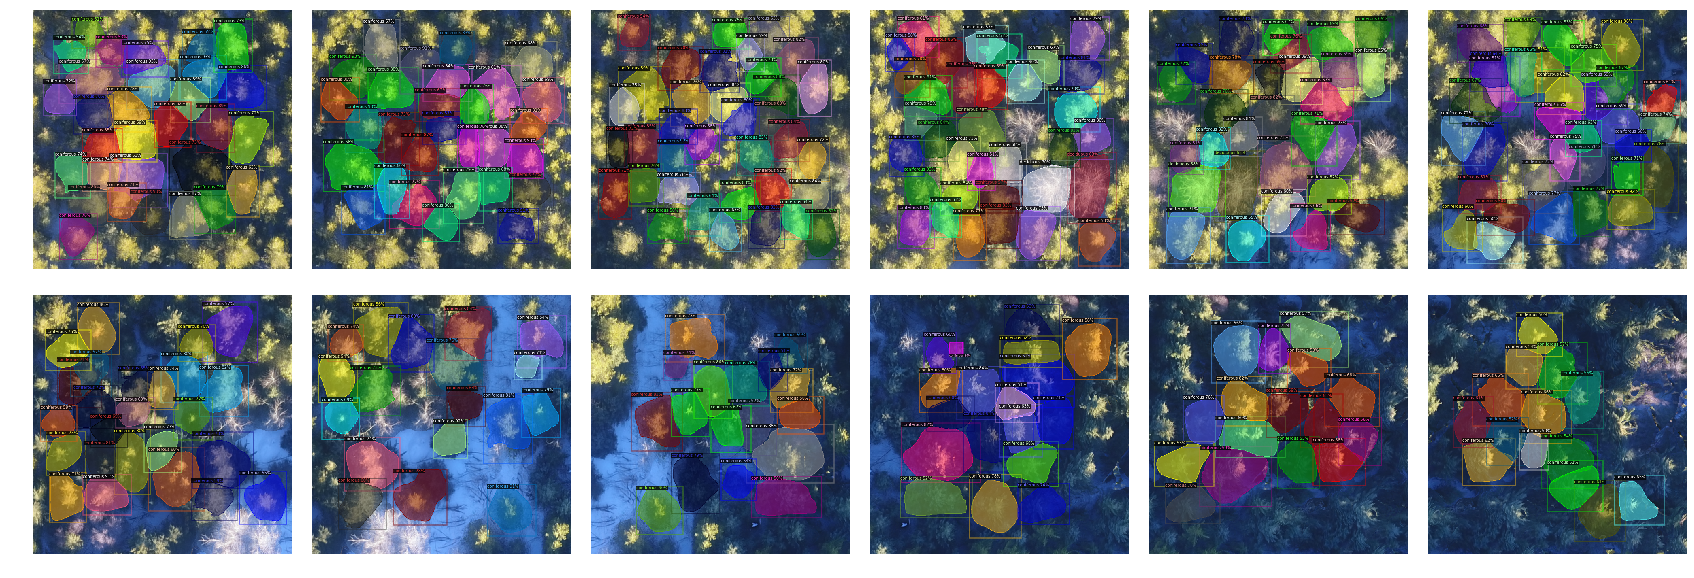

In [55]:
h = 10
fig, axes = plt.subplots(2,6, figsize=(3*h,h))
fig.subplots_adjust(hspace=.1, wspace=0)
i = 595-8 # 505
for ax in axes.ravel():
    dic = data[i]
    img = cv2.imread(dic["file_name"])
    predictions = predictor(img)
    visualizer = Visualizer(img, metadata=metadata) # instance_mode=ColorMode.IMAGE_BW
    vis = visualizer.draw_instance_predictions(predictions["instances"].to("cpu")).get_image()
    ax.imshow(vis)
    ax.set_axis_off()
    i += 1
plt.savefig('poster_demo.png')